# Description

This is a demonstration of multiple subplots of impervious surface proportion per grid cell using matplotlib. This is a critical step prior to classifying the land-use type of each cell in the study area grid because it reveals the distribution of pixels within each cell. Each pixel approximately represents the impervious surface proportion within 30x30 meters in the real world. 

The objective of this script is to plot the cumulative frequency impervious surface pixels within each grid cell of the study area. I'll be playing around with matplotlib and seaborn to see which is easier to use. 

The main reference used for this demonstration is this post in quora:
- https://kratsg.quora.com/Dynamic-Subplots-NumPy-and-PyLab

Other references can be found in these sites:

- [Pyplot Tutorial](http://matplotlib.org/users/pyplot_tutorial.html)
- [Useful tip from the late creator of matplotlib, John Hunter](https://gist.github.com/LeoHuckvale/89683dc242f871c8e69b)
- [Dynamically add/create subplots in matplotlib](http://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib)
- [Dynamically add subplots in matplotlib with more than one column](http://stackoverflow.com/questions/31575399/dynamically-add-subplots-in-matplotlib-with-more-than-one-column)

In [58]:
import rasterio as rio
import time as tm
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterstats as rs

import matplotlib
matplotlib.use('TkAgg')  # from http://stackoverflow.com/questions/37365357/when-i-use-matplotlib-in-jupyter-notebook-it-always-raise-matplotlib-is-curren
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import seaborn as sns
import warnings
from sklearn.preprocessing import normalize, MinMaxScaler

warnings.filterwarnings("ignore")


The code block below visualizes the study area grid and the resampled worldview2 classified image.

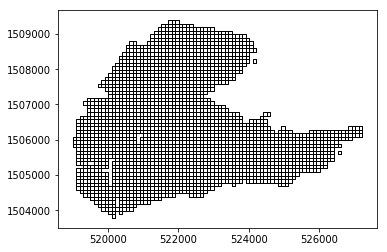

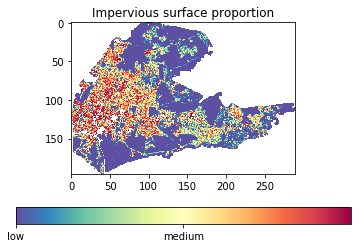

In [49]:
"""
http://stackoverflow.com/questions/15408371/cumulative-distribution-plots-python
http://matplotlib.org/examples/statistics/histogram_demo_cumulative.html

Cumulative frequency plots of impervious surfaces
per training grid cell.
"""

img_dir = 'resampled.tif'
grid_dir = 'grid100.tif'
sa_grid_dir = 'study_area\\study_area.shp'

img = rio.open(img_dir)
grid = rio.open(grid_dir)
pgrid_dir = gpd.read_file(sa_grid_dir)

data = img.read(1)
cgrid = grid.read(1)
pgrid = pgrid_dir

data[data>=1] = np.nan

# plot study area grid
pgrid.plot(color='white')
plt.show()

# plot raster image of impervious surface proportions
fig, ax = plt.subplots()
pax = ax.imshow(data, interpolation='nearest', cmap='Spectral_r' )
ax.set_title('Impervious surface proportion')
cbar = fig.colorbar(pax, ticks=[0., 0.5, 1.0], orientation='horizontal')
cbar.ax.set_xticklabels(['low', 'medium', 'high'])

plt.show()

In this section I attempt plotting the cumulative frequency of each training site using matplotlib.

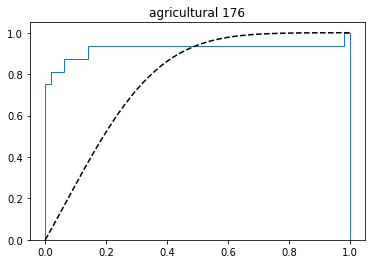

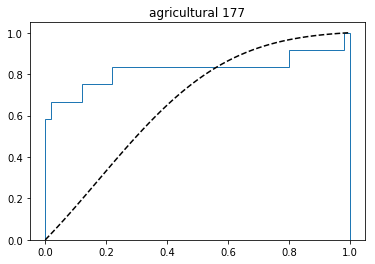

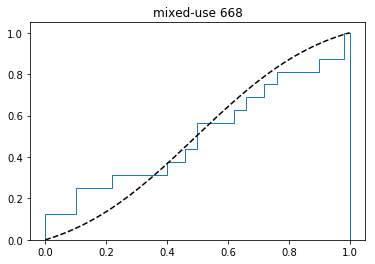

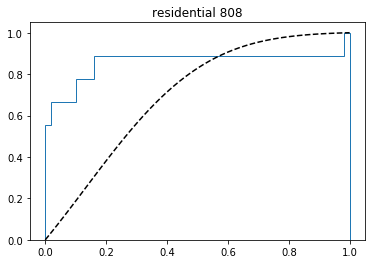

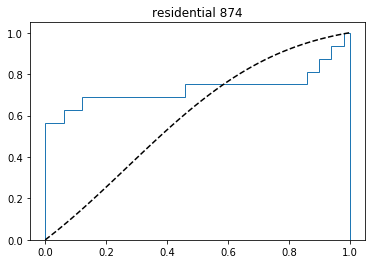

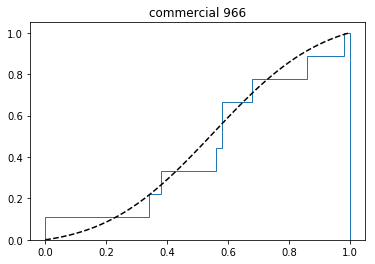

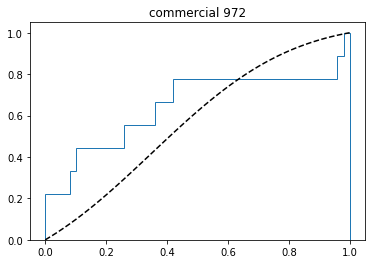

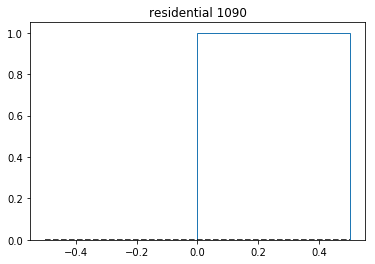

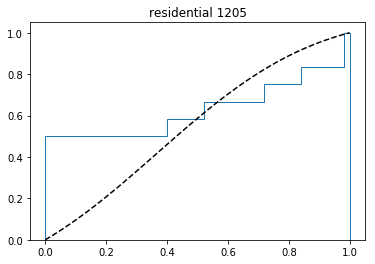

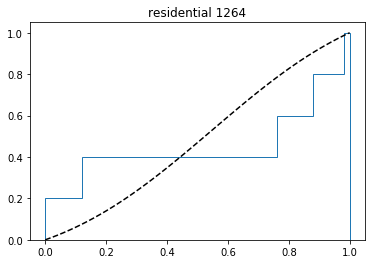

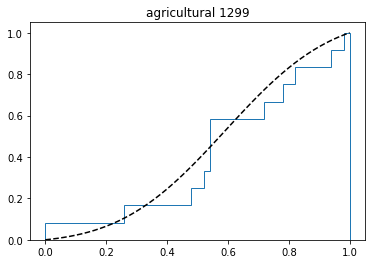

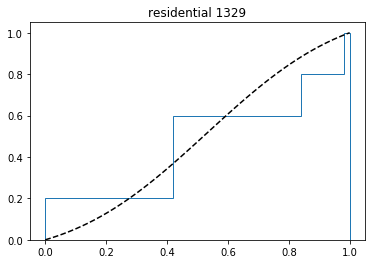

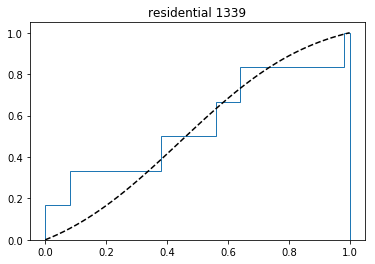

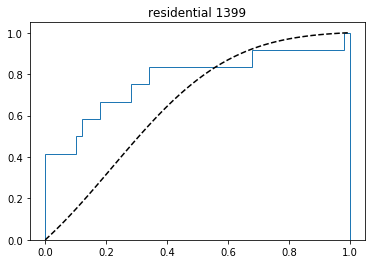

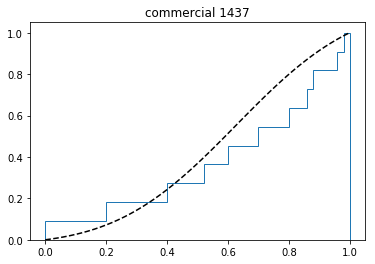

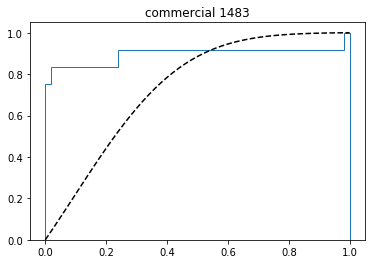

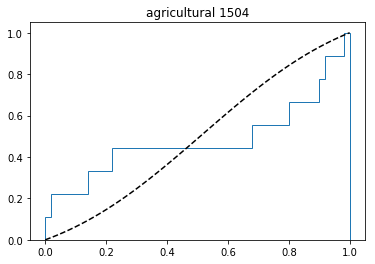

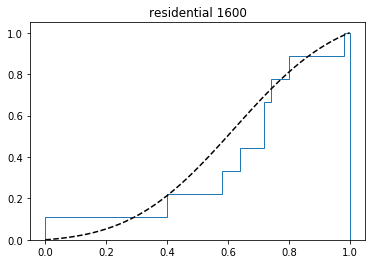

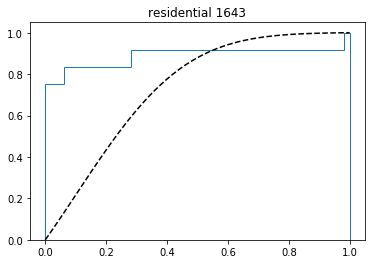

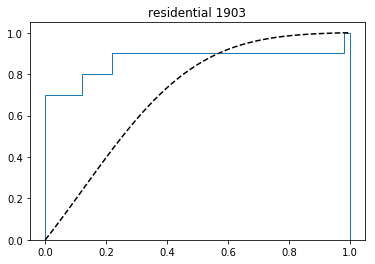

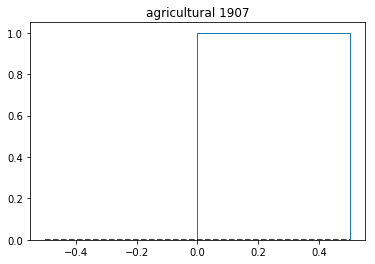

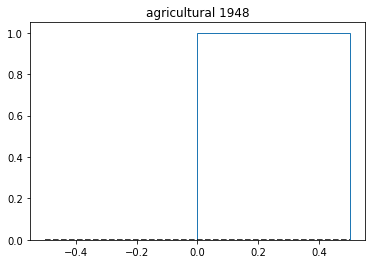

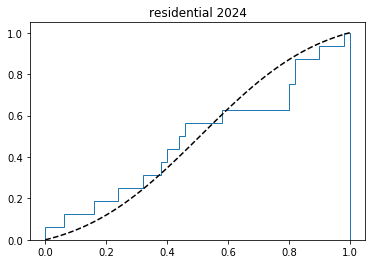

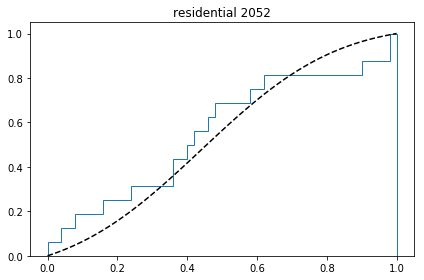

In [38]:

tr_cell_i = pgrid[pgrid['lu_code']!= 0].index

# isolate training grid cells
for i, cell_i in enumerate(tr_cell_i):

    data[data>=1] = np.nan
    cell_pix = data[cgrid==cell_i]
    cell_pix = cell_pix[~np.isnan(cell_pix)] # filter out nodata pixels
    lu_type = pgrid.loc[cell_i, 'lu_type']

    # ignore cells with pixel values of nan
    if len(cell_pix) > 0:

        # scale cell pixels from (0,1)
        scaler = MinMaxScaler()
        cell_pix_norm = scaler.fit_transform(cell_pix)

        plt.figure()
        plt.subplot()
        n, bins, patches = plt.hist(cell_pix_norm, bins=50, histtype='step', normed=1,
                               cumulative=True, label='Empirical')

        # cumulative frequency plotting parameters
        mu = cell_pix_norm.mean()
        sigma = cell_pix_norm.std()
       
        # reference for multiple plots in a grid
        # http://stackoverflow.com/questions/9603230/how-to-use-matplotlib-tight-layout-with-figure
        
        # plot the theoretical cumulative frequency
        y = mlab.normpdf(bins, mu, sigma).cumsum()
        y /= y[-1]
        y[np.isnan(y)] = 0.
        y_norm = scaler.fit_transform(y)

        plt.plot(bins, y_norm, 'k--', linewidth=1.5, label='Theoretical')
        # ax.set_ylabel('Cumulative frequency')
        # ax.set_xlabel('Proportion impervious surface')
        # ax.set_ylim([0., 1.2])
        # ax.set_xlim([-0.2, 1.])
        plt.title(str(lu_type) + ' ' + str(cell_i))
plt.tight_layout()
plt.show()




Here, I attempt to plot using seaborn.